In [120]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [5]:
def nearest_neighbors(N, d, r, kind="strict"):
    """
    Create a d-uniform hypergraph representing nearest neighbor relationships.

    Parameters
    ----------
    N : int
        The total number of nodes.

    d : int
        Size of hyperedges

    r : int
        The range of neighbors to consider. Neighbors within the range [-r, r]
        (excluding the node itself) will be connected.

    Returns
    -------
    xgi.Hypergraph
        A hypergraph object representing the nearest neighbor relationships.

    Raises:
    ------
    """

    r_min = int(np.ceil((d - 1) / 2))
    if r < r_min:
        raise ValueError(f"r must be >= ceil((d - 1) / 2) = {r_min} to have edges.")

    H = xgi.Hypergraph()

    nodes = np.arange(N)

    edges = []
    neighbor_rel_ids = np.concatenate((np.arange(-r, 0), np.arange(1, r + 1)))

    for i in nodes:
        neighbor_ids = i + neighbor_rel_ids
        edge_neighbors_i = combinations(neighbor_ids, d - 1)
        if kind == "strict":
            edge_neighbors_i = [el for el in edge_neighbors_i if max(el) - min(el) <= r]
        edges_i = [(i, *comb) for comb in edge_neighbors_i]
        edges = edges + edges_i

    edges = np.mod(edges, N)

    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    H.cleanup()  # remove duplicate edges
    return H


from itertools import permutations


def adjacency_tensor(H, order):
    N = H.num_nodes
    shape = tuple([N] * (order + 1))
    tensor = np.zeros(shape)

    edges = H.edges.filterby("order", order)
    for id, members in edges.members(dtype=dict).items():
        for idcs in permutations(members):
            tensor[idcs] = 1

    return tensor

In [30]:
N = 100
# H = xgi.complete_hypergraph(N, max_order=2)

r1 = 1
r2 = 1

H2 = nearest_neighbors(N, d=3, r=r2, kind=None)
H1 = nearest_neighbors(N, d=2, r=r1, kind=None)
H = H1 << H2

print(H)

Unnamed Hypergraph with 100 nodes and 200 hyperedges


In [31]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)
adj2 = xgi.adjacency_matrix(H, order=2, sparse=False)
k1_avg = H.nodes.degree(order=1).mean()
k2_avg = H.nodes.degree(order=2).mean()

In [32]:
adjt2 = adjacency_tensor(H, order=2)

In [73]:
def rhs_3_sym_micro(t, psi, omega, k1, k2, r1, r2, triangles):
    N = len(psi)
    triplet = np.zeros(N)

    for i, j, k in triangles:
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    return triplet

In [109]:
def rhs_3_sym_sum(t, psi, omega, k1, k2, r1, r2, adjt2):
    N = len(psi)
    sin_psi = np.sin(psi, dtype=np.longdouble)
    cos_psi = np.cos(psi, dtype=np.longdouble)

    sum_sin_psi = adjt2.dot(sin_psi)
    sum_cos_psi = adjt2.dot(cos_psi)

    triplet = (
        -2 * sum_cos_psi.dot(cos_psi) * sin_psi * cos_psi
        + 2 * sum_sin_psi.dot(sin_psi) * sin_psi * cos_psi
        + sum_cos_psi.dot(sin_psi) * cos_psi**2
        + sum_cos_psi.dot(sin_psi) * sin_psi**2
        + sum_sin_psi.dot(cos_psi) * cos_psi**2
        + sum_sin_psi.dot(cos_psi) * sin_psi**2
    )

    return triplet

In [110]:
# dynamical
k1 = 1  # pairwise coupling strength
k2 = 1  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
psi_init = generate_state(N, kind=ic)

In [111]:
xx = rhs_3_sym_sum(0, psi_init, omega, k1, k2, r1, r2, adjt2)
xx

array([ 1.46813529,  0.3488815 ,  0.38152848, -0.45116082, -1.74926689,
       -0.36479418,  2.80807846, -3.08429695, -1.520432  , -0.3735884 ,
        4.14024404, -2.35688059, -1.58190055,  1.17705767,  1.58958521,
        4.03144116, -1.83163337,  5.37610672, -5.30826949, -6.0934003 ,
        2.30708397, -2.69516321,  1.3725765 , -2.34575028,  0.79276262,
        4.15049776,  0.59626735,  1.19573895,  1.71127521, -2.65869412,
        7.08796743, -0.29411895, -0.41365466,  0.87222283,  1.72326167,
       -1.29307739, -4.36906656,  0.30214859, -0.122591  ,  0.06613681,
        3.08005696, -5.30981919,  1.38868147, -0.20756775, -0.12866369,
        1.8878486 ,  0.3111763 , -3.27658529, -1.37355323,  0.96655234,
        2.68654031,  1.99352019, -3.24830387,  4.50597269,  2.27882609,
       -2.66865893,  4.31348396,  2.10161669, -0.39331042,  2.46413614,
       -2.96051393, -2.64753988, -5.3788069 , -1.21346008,  1.86925179,
       -1.88153197, -0.86483691,  4.06980925,  3.1411163 , -0.42

In [112]:
yy = rhs_3_sym_micro(0, psi_init, omega, k1, k2, r1, r2, triangles)
yy

array([-2.95850378e-01,  1.14322529e+00, -1.24438902e+00,  3.07687946e-03,
        3.40629507e+00, -3.88255982e-01,  9.96613165e-01, -2.25926474e+00,
       -1.34864673e+00,  5.55033258e-01,  3.97034355e+00,  5.09212132e+00,
       -1.26639822e+00, -9.21297281e-01,  5.83628231e-01,  3.99847733e+00,
        3.04087297e+00, -5.08150578e+00, -4.58570617e+00, -3.91583064e+00,
        8.85987962e-01,  2.16376945e+00,  1.17772232e+00,  1.37591240e+00,
        3.26869575e-01,  2.95460696e+00,  1.72649605e-01, -3.01086691e+00,
        1.69353473e+00,  1.12599789e-01, -1.76519493e+00, -2.94104195e-01,
       -2.38934862e+00, -1.05912855e+00,  1.51694806e+00, -2.45342141e+00,
       -3.10839520e-01, -1.95938526e+00, -1.06358262e-01,  6.64433306e-01,
        6.22336215e-01, -5.25882286e+00, -4.48639058e-01, -2.43761222e+00,
        4.52131839e+00, -1.79310891e+00,  2.34386491e+00,  3.12553172e+00,
       -1.71755818e+00,  9.65933448e-01,  8.57834314e-01,  1.20683706e+00,
        5.85929705e-01, -

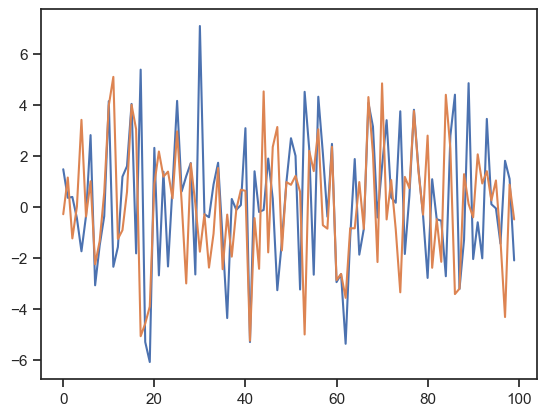

In [113]:
plt.plot(xx)
plt.plot(yy)

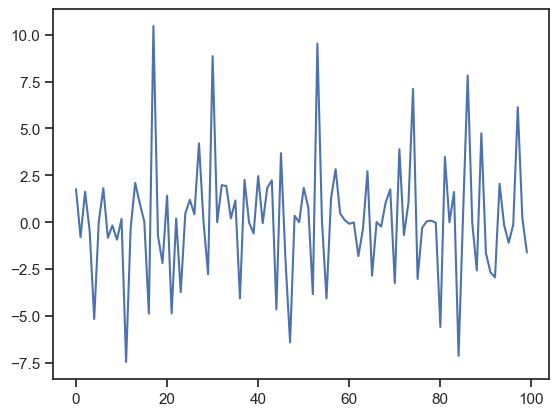

In [114]:
plt.plot(xx - yy)

In [100]:
v = np.ones(N) * 2

shape = tuple([N] * 3)
A = np.ones(shape)

In [101]:
A.dot(v)

array([[200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       ...,
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.]])

In [102]:
np.tensordot(A, v, 1)

array([[200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       ...,
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.]])

In [115]:
np.sin(psi_init)

array([ 0.70365364, -0.61023093, -0.98619957, -0.45234862,  0.95923969,
       -0.26305089,  0.92838216, -0.57216679, -0.2476812 , -0.99961968,
       -0.13403659, -0.93140842, -0.33132784,  0.80858127,  0.53673915,
        0.06314888,  0.99499013, -0.98267652,  0.35948577,  0.57131779,
       -0.91832958,  0.83109843,  0.95792255,  0.90729302, -0.92955119,
       -0.55052218,  0.38102943,  0.9818735 ,  0.07300973,  0.87225868,
       -0.94163569, -0.00482614,  0.78434195,  0.99947966,  0.64468837,
       -0.94196578, -0.72643115, -0.99070736,  0.15300217,  0.99822727,
        0.50394521,  0.0699766 ,  0.48620532,  0.59567582, -0.93433231,
       -0.86648859,  0.90587228,  0.99549731,  0.9622809 , -0.01894109,
       -0.76300268, -0.78595118, -0.84179425,  0.96495351, -0.12111448,
       -0.79019819,  0.55447281,  0.74629278, -0.42036222, -0.18487928,
        0.12402898, -0.04191506,  0.86486486, -0.32093412,  0.98610921,
       -0.8617419 ,  0.26037729, -0.78239634, -0.34261829,  0.98